In [116]:
import os
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
import seaborn as sns
sns.set_style("whitegrid")
import matplotlib.pyplot as plt
from typing import List
from scipy.stats import linregress
from matplotlib.patches import Rectangle
from plot import load_logs, plot_runs, add_values_from_normal_runs, PV_MAP
# refresh files

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [117]:
TUM_colors =  {
    "TUMBlue": "#0065BD",
    "TUMSecondaryBlue": "#005293",
    "TUMSecondaryBlue2": "#003359",
    "TUMBlack": "#000000",
    "TUMWhite": "#FFFFFF",
    "TUMDarkGray": "#333333",
    "TUMGray": "#808080",
    "TUMLightGray": "#CCCCC6",
    "TUMAccentGray": "#DAD7CB",
    "TUMAccentOrange": "#E37222",
    "TUMAccentGreen": "#A2AD00",
    "TUMAccentLightBlue": "#98C6EA",
    "TUMAccentBlue": "#64A0C8"
}

In [118]:
BASE_DIR = "/home/getznerj/Documents/Thesis/Thesis Final Experiments"

In [119]:
log_dir = os.path.join(BASE_DIR, "loss_weighing")
data = load_logs(log_dir = log_dir, fine_tuning="fine_tuning" in log_dir)

In [120]:
age_no_dp_key = [key for key in data.keys() if "age" in key and "noDP" in key][0]
age_dp_key = [key for key in data.keys() if "age" in key and not "noDP" in key][0]
sex_no_dp_key = [key for key in data.keys() if "sex" in key and "noDP" in key][0]
sex_dp_key = [key for key in data.keys() if "sex" in key and not "noDP" in key][0]

In [121]:
data_noDP_age = data[age_no_dp_key]
data_noDP_sex = data[sex_no_dp_key]
data_DP_age = data[age_dp_key]
data_DP_sex = data[sex_dp_key]

In [122]:
metrics_age = [col for col in data_noDP_age.columns if "subgroup" in col] 
metrics_sex = [col for col in data_noDP_sex.columns if "subgroup" in col]

In [123]:
data_noDP_age = data_noDP_age.loc[data_noDP_age.weight == 0.0001]
data_DP_age = data_DP_age.loc[data_DP_age.weight == 0.0001]
data_noDP_sex = data_noDP_sex.loc[data_noDP_sex.weight == 0.0001]
data_DP_sex = data_DP_sex.loc[data_DP_sex.weight == 0.0001]

In [124]:
data_noDP_age = data_noDP_age[["protected_attr", "protected_attr_percent"] + metrics_age]
data_noDP_age = data_noDP_age.rename(columns={metric: PV_MAP["age"][1] if PV_MAP["age"][1] in metric else PV_MAP["age"][0] for metric in metrics_age})
data_noDP_sex = data_noDP_sex[["protected_attr", "protected_attr_percent"] + metrics_sex]
data_noDP_sex = data_noDP_sex.rename(columns={metric: PV_MAP["sex"][1] if PV_MAP["sex"][1] in metric else PV_MAP["sex"][0] for metric in metrics_sex})

data_DP_age = data_DP_age[["protected_attr", "protected_attr_percent"] + metrics_age]
data_DP_age = data_DP_age.rename(columns={metric: PV_MAP["age"][1] if PV_MAP["age"][1] in metric else PV_MAP["age"][0] for metric in metrics_age})
data_DP_sex = data_DP_sex[["protected_attr", "protected_attr_percent"] + metrics_sex]
data_DP_sex = data_DP_sex.rename(columns={metric: PV_MAP["sex"][1] if PV_MAP["sex"][1] in metric else PV_MAP["sex"][0] for metric in metrics_sex})

In [125]:
id_vars = ["protected_attr", "protected_attr_percent"]
data_noDP_age_melted = data_noDP_age.melt(id_vars=id_vars, value_vars=["young","old"], var_name=f"group", value_name="value")
data_noDP_age_melted["Mode"] = "without DP"
data_DP_age_melted = data_DP_age.melt(id_vars=id_vars, value_vars=["young", "old"], var_name=f"group",value_name="value")
data_DP_age_melted["Mode"] = "with DP"

data_noDP_sex_melted = data_noDP_sex.melt(id_vars=id_vars, value_vars=["female","male"], var_name=f"group", value_name="value")
data_noDP_sex_melted["Mode"] = "without DP"
data_DP_sex_melted = data_DP_sex.melt(id_vars=id_vars, value_vars=["female", "male"], var_name=f"group",value_name="value")
data_DP_sex_melted["Mode"] = "with DP"
df = pd.concat([data_noDP_sex_melted, data_DP_sex_melted], axis=0)
df.value = df.value * 100

In [126]:
df = df.loc[df.protected_attr_percent == 0.5]

In [127]:
fontSize = 25
plt.figure(figsize=(10, 10))

rc={"figure.dpi": 300, 'savefig.dpi': 300, 'axes.labelsize': fontSize, 'axes.titlesize': fontSize, 'font.size': fontSize, 'legend.fontsize': fontSize*0.8, 'axes.facecolor':'#EEEEEE', 'figure.facecolor':'#EEEEEE' }
plt.rcParams.update(rc)

<Figure size 3000x3000 with 0 Axes>

In [128]:
palette = {
    #"old":TUM_colors["TUMAccentBlue"], 
    "old":"#9FC5E8", 
    "young":"#F6B26B", 
    #"young":TUM_colors["TUMAccentOrange"], 
    "male":"#6D9EEB", 
    #"male":TUM_colors["TUMAccentBlue"], 
    "female":"#F6B26B"
    #"female":TUM_colors["TUMAccentOrange"]
}

Text(0, 0.5, 's-AUC')

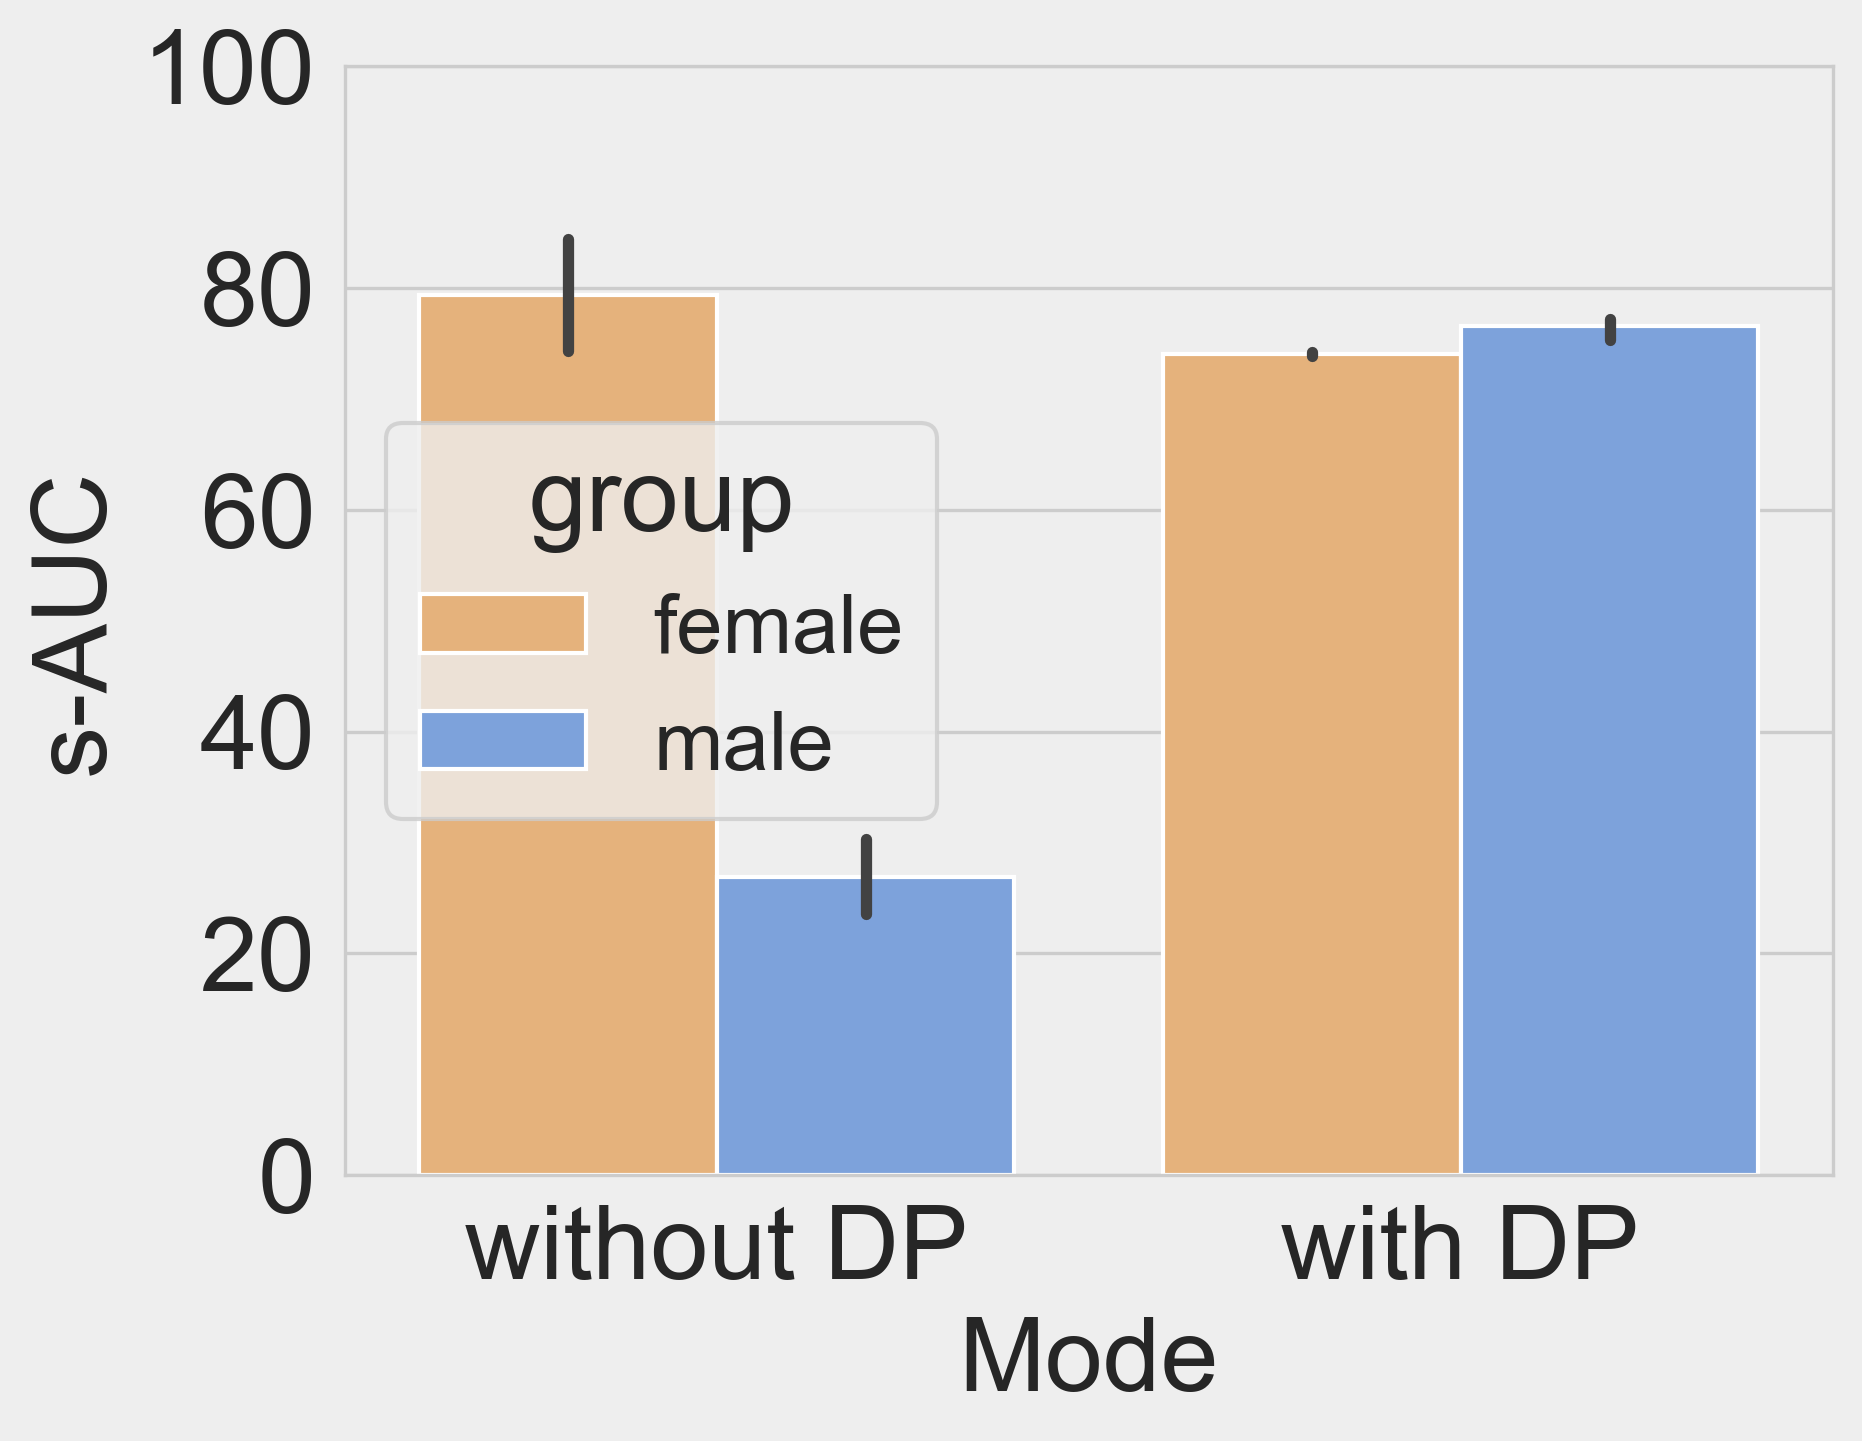

In [130]:
sns.barplot(data=df, x="Mode", y="value", hue="group", palette=palette)
plt.ylim(0, 100)
plt.xlabel("Mode")
plt.ylabel("s-AUC")

In [121]:
def load_csvs_into_df(dir):
    dirs = [os.path.join(dir,d) for d in os.listdir(dir) if os.path.isdir(os.path.join(dir,d))]
    dfs = []
    for d in dirs:
        seeds = [f for f in os.listdir(os.path.join('./',d)) if f.startswith('seed')]
        score_var = d.split("/")[-1].split("-")[0]
        dp = not "noDP" in d
        if dp:
            num_samples = int(d.split("/")[-1].split("-")[-1].split("_")[0])
        else:
            num_samples = int(d.split("/")[-1].split("-")[-1])
        for seed in seeds:
            results = [f for f in os.listdir(os.path.join(d,seed)) if f.startswith('test_results')]
            for results_dir in results:
                results_df = pd.read_csv(os.path.join(d, seed, results_dir))
                results_df["score_var"] = score_var
                results_df["num_samples"] = num_samples
                dfs.append(results_df)
    return pd.concat(dfs, ignore_index=True)

In [122]:
data_noDP = load_csvs_into_df(os.path.join(BASE_DIR, "core-set-selection/2023-11-09 20:06:05-FAE-rsna-balanced-subsetperformance-noDP/old_percent_05_bestBytest"))
data_noDP = data_noDP.loc[data_noDP.dataset == "rsna"]
data_DP = load_csvs_into_df(os.path.join(BASE_DIR, "core-set-selection/2023-12-07 16:22:58-FAE-rsna-balanced-subsetperformance-DP/old_percent_05_bestBytest"))

In [123]:
metrics = (
    f"test/old_subgroupAUROC", f"test/young_subgroupAUROC",
    f"test/female_subgroupAUROC", f"test/male_subgroupAUROC"
)

In [124]:
data_noDP = data_noDP[[*metrics, "dataset", "seed", "score_var","num_samples"]]
data_noDP = data_noDP.melt(id_vars=["seed", "dataset", "score_var","num_samples"], var_name="group", value_name="value")

In [125]:
data_noDP = data_noDP.loc[data_noDP.num_samples == 250]
data_noDP = data_noDP.loc[(data_noDP.group == "test/female_subgroupAUROC") | (data_noDP.group == "test/male_subgroupAUROC")]
data_noDP = data_noDP.loc[data_noDP.score_var == "female_subgroupAUROC"]
data_noDP["Mode"] = "without DP"

In [126]:
data_DP = data_DP[[*metrics, "dataset", "seed", "score_var","num_samples"]]
data_DP = data_DP.melt(id_vars=["seed", "dataset", "score_var","num_samples"], var_name="group", value_name="value")

In [127]:
data_DP = data_DP.loc[data_DP.num_samples == 250]
data_DP = data_DP.loc[(data_DP.group == "test/female_subgroupAUROC") | (data_DP.group == "test/male_subgroupAUROC")]
data_DP = data_DP.loc[data_DP.score_var == "female_subgroupAUROC"]
data_DP["Mode"] = "with DP"

In [128]:
df = pd.concat([data_noDP, data_DP], axis=0)
df.value = df.value * 100

In [129]:
# replace metric names
df.group = df.group.replace({"test/female_subgroupAUROC": "female", "test/male_subgroupAUROC": "male"})

Text(0, 0.5, 's-AUC')

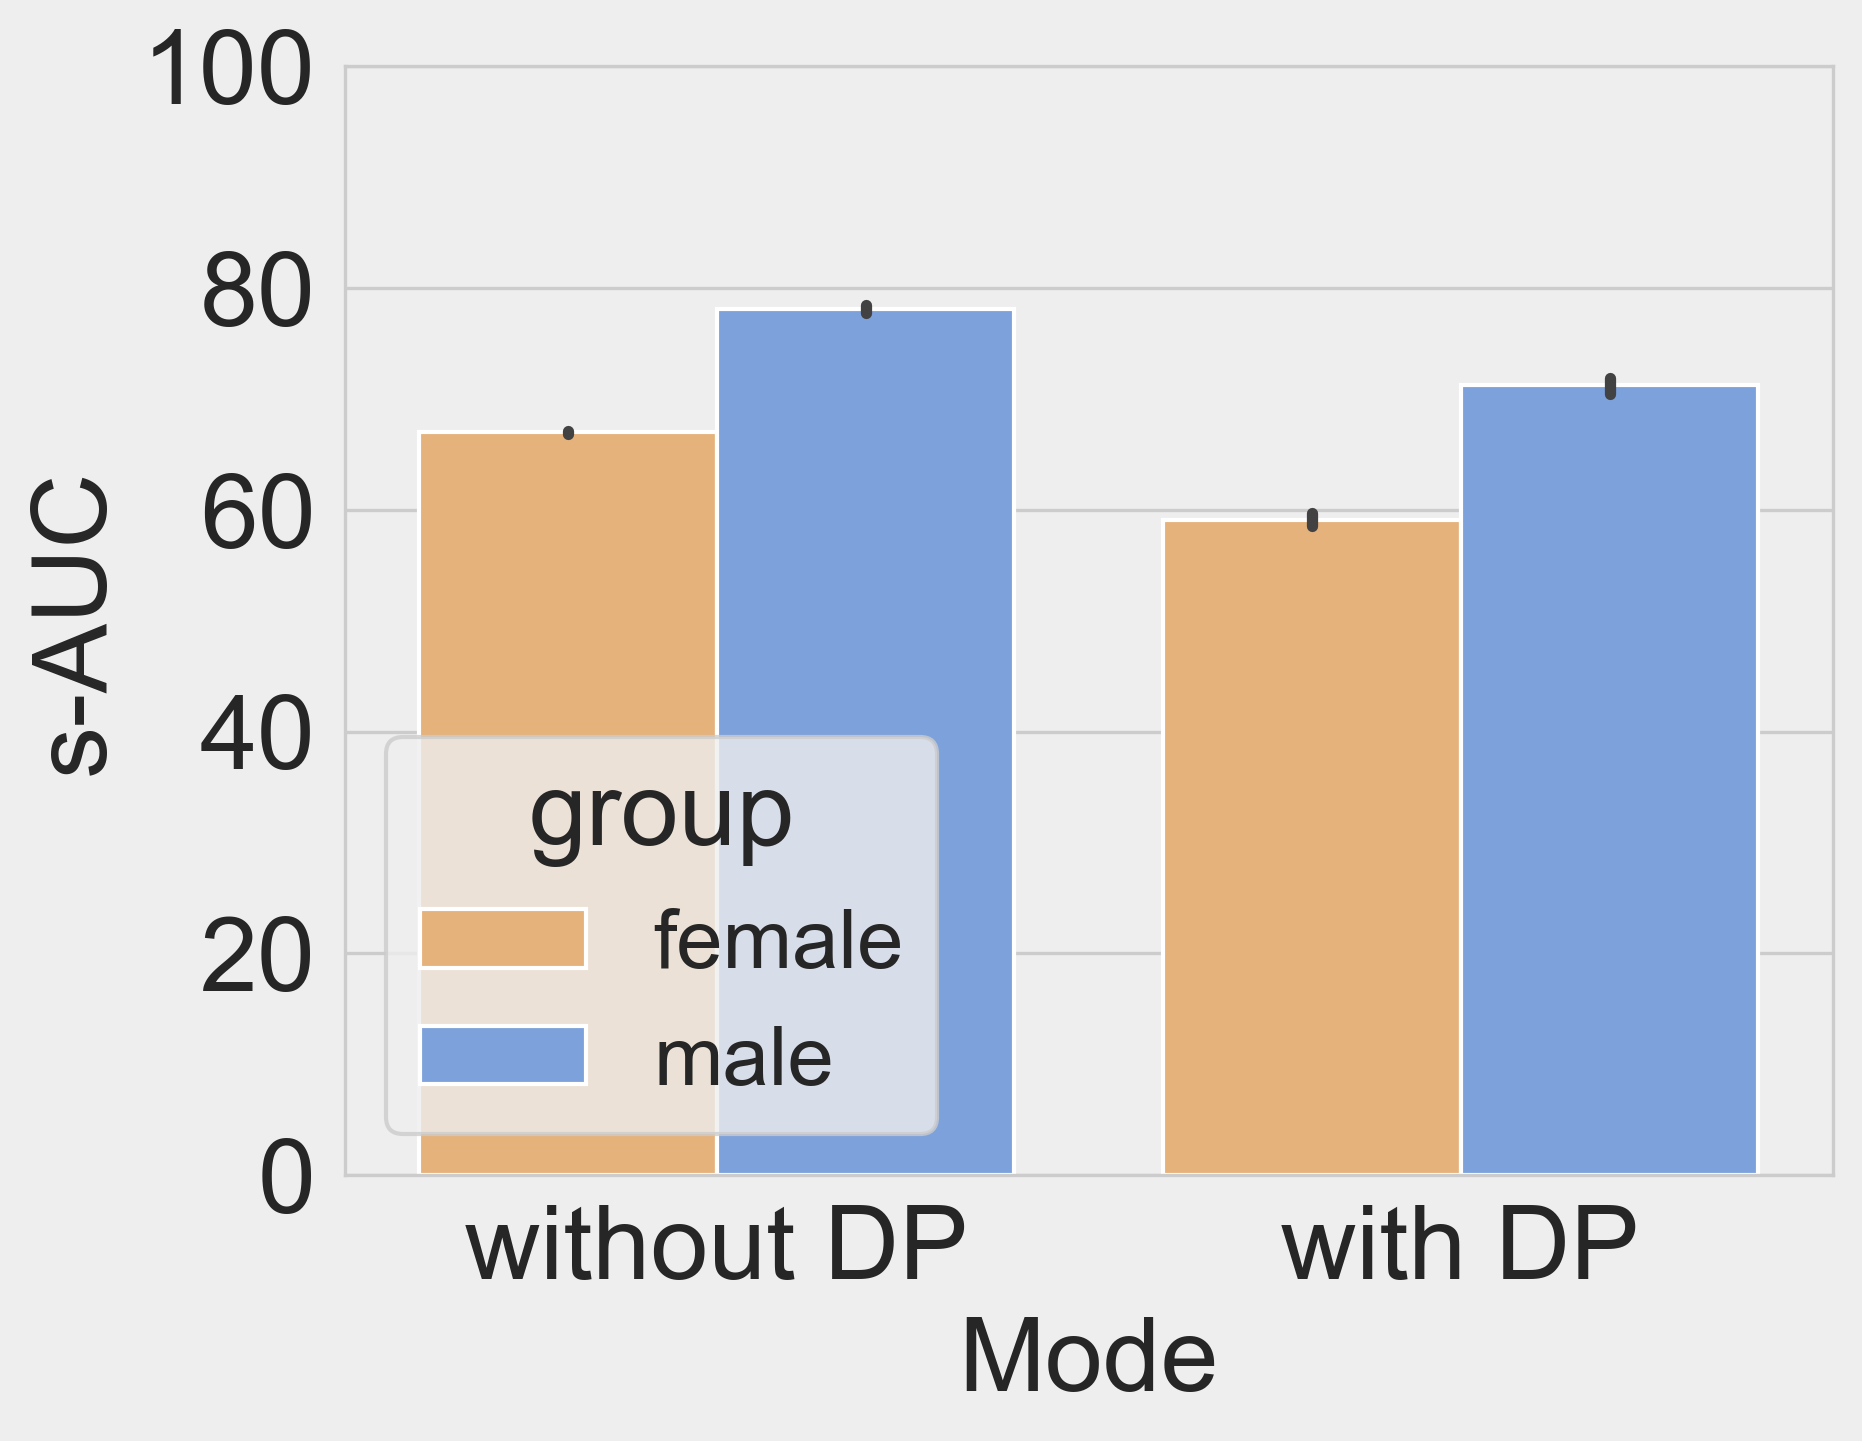

In [130]:
sns.barplot(data=df, x="Mode", y="value", hue="group", palette=palette)
plt.ylim(0, 100)
plt.xlabel("Mode")
plt.ylabel("s-AUC")